# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# USERS

profile DataFrame analysis conclusions:
* There are 17 000 users
* 14 825 users have all the information
* for the users with age '118' we will assume that the user diden't provide this information.' 
* 2 175 users dosen't have 'age' , 'gender' and ' income' information

In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [27]:
print('Number of users: ' , profile.shape[0])
print('Number of user listed more than one time:' , (profile.shape[0] - len(profile['id'].unique())))

Number of users:  17000
Number of user listed more than one time: 0


Higher value in age feature: 16999    62
Name: age, dtype: int64
Number of NaN values: 0
Note: There are 2175 users with a value of 118 - we can assume that the user did not provide this information.


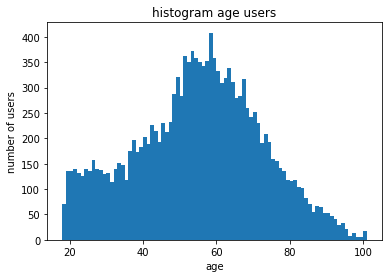

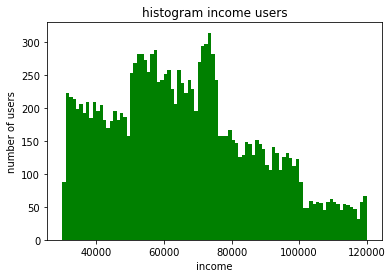

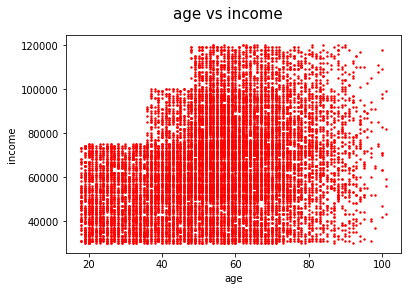

In [49]:
#user_age = profile.groupby('age')['id'].count()
user_age = profile[profile['age'] != 118]['age']
user_income = profile[profile['age'] != 118]['income']


print ('Higher value in age feature:' , user_age[-1:])
print ('Number of NaN values:' , profile["age"].isna().sum())
print ('Note: There are 2175 users with a value of 118 - we can assume that the user did not provide this information.')

f1, ax1 = plt.subplots()
ax1.set_xlabel('age');
ax1.set_ylabel('number of users');
ax1.set_title('histogram age users');
ax1.hist(user_age, 83);

f2, ax2 = plt.subplots()
ax2.set_xlabel('income');
ax2.set_ylabel('number of users');
ax2.set_title('histogram income users');
ax2.hist(user_income, 90 , color='g');

f3, ax3 = plt.subplots()
f3.suptitle('age vs income', fontsize=15)
plt.xlabel('age')
plt.ylabel('income')
ax3.scatter(user_age.values , user_income.values ,  s=2 , c='r')
plt.show();


In [50]:
user_became_member = profile.groupby('became_member_on')['id'].count()
print('first user' , user_became_member[:1])
print('Last user' , user_became_member[-1:])
print ('Number of NaN values:' , profile["became_member_on"].isna().sum())
print ('Note: change type INT to datetime?.')

first user became_member_on
20130729    1
Name: id, dtype: int64
Last user became_member_on
20180726    22
Name: id, dtype: int64
Number of NaN values: 0
Note: change type INT to datetime?.


In [51]:
user_gender = profile.groupby('gender')['id'].count()
print(user_gender)
print ('Number of NaN values:' , profile["gender"].isna().sum())
print ('Note: there are also 2175 users without information in "gender", the same number of users that have 118 years, will they be the same users?')
print ('users with 118 years and no information in gender:' , profile[profile['age'] == 118]["gender"].isna().sum())
print('yes, the users that have 118 years are the same that does not have gender information, more reason to assume that the user did not give this information.')

gender
F    6129
M    8484
O     212
Name: id, dtype: int64
Number of NaN values: 2175
Note: there are also 2175 users without information in &quot;gender&quot;, the same number of users that have 118 years, will they be the same users?
users with 118 years and no information in gender: 2175
yes, the users that have 118 years are the same that does not have gender information, more reason to assume that the user did not give this information.


Range income: from 30000.0 to 120000.0
Number of NaN values: 2175
again 2175 nan values
users with 118 years and no information in income: 2175


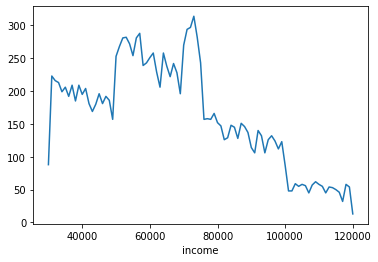

In [52]:
user_income = profile.groupby('income')['id'].count()
print('Range income: from' ,  user_income.index.min() , 'to' , user_income.index.max())
print ('Number of NaN values:' , profile["income"].isna().sum())
print('again 2175 nan values')
print ('users with 118 years and no information in income:' , profile[profile['age'] == 118]["income"].isna().sum())
user_income.plot();

# PROMOTIONS / OFFER

portfolio DataFrame analysis conclusions:
* There are 10 offers
* There are 3 types of offers: bogo , informational and discount
* There are no Nan values

In [7]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [53]:
print('Number of offers: ' , portfolio.shape[0])
print('Number of offers listed more than one time:' , (portfolio.shape[0] - len(portfolio['id'].unique())))

Number of offers:  10
Number of offers listed more than one time: 0


In [54]:
offer_channel_lst = portfolio.channels.tolist()
unique_offer_channel_lst = []
for x in offer_channel_lst: 
        # check if exists in unique_list or not 
        if x not in unique_offer_channel_lst: 
            unique_offer_channel_lst.append(x)
print(unique_offer_channel_lst)
print('there are 4 combinations of channels to interact with the offer, "email" is in all of them')

[[&#39;email&#39;, &#39;mobile&#39;, &#39;social&#39;], [&#39;web&#39;, &#39;email&#39;, &#39;mobile&#39;, &#39;social&#39;], [&#39;web&#39;, &#39;email&#39;, &#39;mobile&#39;], [&#39;web&#39;, &#39;email&#39;]]
there are 4 combinations of channels to interact with the offer, &quot;email&quot; is in all of them


In [56]:
ordered_portfolio = portfolio.sort_values(by=['offer_type' , 'difficulty' ,'duration' , 'reward'])
ordered_portfolio

,reward,channels,difficulty,duration,offer_type,id
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed


# ACTIONS / EVENT

transcript DataFrame analysis conclusions:

**event**

* offer completed     33579
* offer received      76277
* offer viewed        57725
* transaction        138953


* 75.68% offers sent were viewed
* 58.17% offers viewed were completed

**users**
* All 17 000 users are in the dataframe
* 16 578 users have made at least one transaction

trensaction
* Transaction event is not realted with an offer event, thus we could split the feature value into 'offer id' and 'amount'. 

offer completed
* offer completed has a value of 'offer_id' and 'reward' note: there is a difference in the name 'offer_id' ad 'offer id'

The 'amount' of the transaction could be added to the profie of the user by number of transactions and total amount, to know how much an user spend and to have an average of how much s/he spend.

In [4]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [5]:
print('Number of events:' , transcript.shape[0])
print('Number of users:' , len(transcript.groupby('person')['event'].count()))

Number of events: 306534
Number of users: 17000


In [6]:
event = transcript.groupby('event')['person'].count()
event

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

In [7]:
print('porcentage offer viewed/recived:' , (event.loc['offer viewed'] * 100) / event.loc['offer received'] , '%')
print('porcentage offer completed/recived:' , (event.loc['offer completed'] * 100) / event.loc['offer received'] , '%')
print('porcentage offer completed/viewed:' , (event.loc['offer completed'] * 100) / event.loc['offer viewed'] , '%')

porcentage offer viewed/recived: 75.67812053436816 %
porcentage offer completed/recived: 44.02244451145168 %
porcentage offer completed/viewed: 58.17063663923776 %


In [8]:
transaction = transcript[transcript['event'] == 'transaction']
transaction.head()

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


In [9]:
print('Number of users that made at least one transaction:' , len(transaction.groupby('person')['event'].count()))

Number of users that made at least one transaction: 16578


In [11]:
df = pd.concat([transcript.drop(['value'], axis=1), transcript['value'].apply(pd.Series)], axis=1)
df

,person,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,3.53,NaN,NaN


In [13]:
df['offer_id'].unique().tolist()

[nan,
 &#39;2906b810c7d4411798c6938adc9daaa5&#39;,
 &#39;fafdcd668e3743c1bb461111dcafc2a4&#39;,
 &#39;9b98b8c7a33c4b65b9aebfe6a799e6d9&#39;,
 &#39;ae264e3637204a6fb9bb56bc8210ddfd&#39;,
 &#39;4d5c57ea9a6940dd891ad53e9dbe8da0&#39;,
 &#39;2298d6c36e964ae4a3e7e9706d1fb8c2&#39;,
 &#39;f19421c1d4aa40978ebb69ca19b0e20d&#39;,
 &#39;0b1e1539f2cc45b7b9fa7c272da2e1d7&#39;]

In [15]:
type_2_offers = ['5a8bc65990b245e5a138643cd4eb9837' , '3f207df678b143eea3cee63160fa8bed']


offer_type_2_a = df[df['offer id'] == '5a8bc65990b245e5a138643cd4eb9837']['time']

,person,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,NaN,19.89,NaN,NaN
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,NaN,17.78,NaN,NaN
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,NaN,19.67,NaN,NaN
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,NaN,29.72,NaN,NaN
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,NaN,23.93,NaN,NaN
